In [1]:
%matplotlib inline

In [2]:
import cupy as cp
import numpy as np
import pylab as plt
import time
import pandas as pd
import logging

import dask.bag as db
from dask.diagnostics import ProgressBar

from astropy import units as u
import setigen as stg
import matplotlib.pyplot as plt

from cupyimg.skimage.feature import peak_local_max
from cupyx.scipy.ndimage import uniform_filter1d

import hdf5plugin
import h5py
from copy import deepcopy

blosc filter already loaded, skip it.


## Dedoppler Kernel

In [3]:
logger_name = 'hyperseti'
logger = logging.getLogger(logger_name)
logger.setLevel(logging.CRITICAL)
#logger.setLevel(logging.INFO)

dedoppler_kernel = cp.RawKernel(r'''
extern "C" __global__
    __global__ void dedopplerKernel
        (const float *data, float *dedopp, int *shift, int F, int T)
        /* Each thread computes a different dedoppler sum for a given channel
        
         F: N_frequency channels
         T: N_time steps
        
         *data: Data array, (T x F) shape
         *dedopp: Dedoppler summed data, (D x F) shape
         *shift: Array of doppler corrections of length D.
                 shift is total number of channels to shift at time T
        */
        {
        
        // Setup thread index
        const int tid = blockIdx.x * blockDim.x + threadIdx.x;
        const int d   = blockIdx.y;   // Dedoppler trial ID
        const int D   = gridDim.y;   // Number of dedoppler trials

        // Index for output array
        const int dd_idx = d * F + tid;
        int idx = 0;
        
        for (int t = 0; t < T; t++) {
                            // timestep    // dedoppler trial offset
            idx  = tid + (F * t)      + (shift[d] * t / T);
            if (idx < F * T && idx > 0) {
                dedopp[dd_idx] += data[idx];
              }
            }
        }
''', 'dedopplerKernel')


def _preprocess(data, return_space='cpu'):
    """ Apply preprocessing steps on GPU
    
    Currently just applies normalisation ( data - mean) / stdev
    
    Args: 
        data (np/cp.array): Data to preprocess
        return_space ('cpu' or 'gpu'): Returns array in CPU or GPU space
        
    Returns: d_gpu (cp.array): Preprocessed data
    """
    
    # Copy over to GPU if required
    d_gpu = cp.asarray(data.astype('float32'))
    
    # Normalise
    t0 = time.time()
    d_median = cp.median(d_gpu)
    d_std  = cp.std(d_gpu)
    d_gpu = (d_gpu - d_median) / d_std
    t1 = time.time()
    logger.info(f"Normalisation time: {(t1-t0)*1e3:2.2f}ms")
    
    if return_space == 'cpu':
        return cp.asnumpy(d_gpu)
    else:
        return d_gpu
    
    
def dedoppler(data, metadata, max_dd, min_dd=None, apply_preprocessing=True, return_space='cpu'):
    """ Apply brute-force dedoppler kernel to data
    
    Args:
        data (np.array): Numpy array with shape (N_timestep, N_channel)
        metadata (dict): Metadata dictionary, should contain 'df' and 'dt'
                         (frequency and time resolution)
        max_dd (float): Maximum doppler drift in Hz/s to search out to
        min_dd (float): Minimum doppler drift to search
        apply_preprocessing (bool): Apply preprocessing to normalise data
        return_space ('cpu' or 'gpu'): Returns array in CPU or GPU space
    
    Returns:
        dd_vals, dedopp_gpu (np.array, np/cp.array): 
    """
    if min_dd is None:
        min_dd = np.abs(max_dd) * -1
    
    # Compute minimum possible drift (delta_dd)
    N_time, N_chan = data.shape
    obs_len  = N_time * metadata['dt'].to('s').value
    delta_dd = metadata['df'].to('Hz').value / obs_len  # e.g. 2.79 Hz / 300 s = 0.0093 Hz/s
    
    # Compute dedoppler shift schedules
    N_dopp_upper   = int(max_dd / delta_dd)
    N_dopp_lower   = int(min_dd / delta_dd)
    
    if N_dopp_upper > N_dopp_lower:
        dd_shifts      = np.arange(N_dopp_lower, N_dopp_upper + 1, dtype='int32')
    else:
        dd_shifts      = np.arange(N_dopp_upper, N_dopp_lower + 1, dtype='int32')
        
    dd_shifts_gpu  = cp.asarray(dd_shifts)
    N_dopp = len(dd_shifts)
    
    # Copy data over to GPU
    d_gpu = cp.asarray(data.astype('float32'))
    
    if apply_preprocessing:
        d_gpu = _preprocess(d_gpu, return_space='gpu')

    # Allocate GPU memory for dedoppler data
    dedopp_gpu = cp.zeros((N_dopp, N_chan), dtype=cp.float32)
    
    # Setup grid and block dimensions
    F_block = np.min((N_chan, 1024))
    F_grid  = N_chan // F_block
    
    # Launch kernel
    t0 = time.time()
    #print(dd_shifts)
    logger.debug("Kernel shape (grid, block)", (F_grid, N_dopp), (F_block,))
    dedoppler_kernel((F_grid, N_dopp), (F_block,), 
                     (d_gpu, dedopp_gpu, dd_shifts_gpu, N_chan, N_time)) # grid, block and arguments
    t1 = time.time()
    logger.info(f"Kernel time: {(t1-t0)*1e3:2.2f}ms")
    
    # Compute drift rate values in Hz/s corresponding to dedopp axis=0
    dd_vals = dd_shifts * delta_dd
    
    # Copy back to CPU if requested
    if return_space == 'cpu':
        dedopp_cpu = cp.asnumpy(dedopp_gpu)
        return dd_vals, dedopp_cpu
    else:
        return cp.asarray(dd_vals), dedopp_gpu


def _hitsearch(drift_trials, dedopp, metadata, threshold=10, min_distance=100):
    """ Search for hits using peak_local_max method 
    
    Args:
        dedopp (np.array): Dedoppler search array of shape (N_trial, N_chan)
        drift_trials (np.array): List of dedoppler trials corresponding to dedopp N_trial axis
        metadata (dict): Dictionary of metadata needed to convert from indexes to frequencies etc
        threshold (float): Threshold value (absolute) above which a peak can be considered
        min_distance (int): Minimum distance in pixels to nearest peak
    
    Returns:
        results (pd.DataFrame): Pandas dataframe of results, with columns 
                                    driftrate: Drift rate in hz/s
                                    f_start: Start frequency channel
                                    snr: signal to noise ratio
                                    driftrate_idx: Index in driftrate array
                                    channel_idx: Index in frequency array
    """
    
    # Unfortunately we need a CPU copy of the dedoppler for peak finding
    # This means lots of copying back and forth, so potential bottleneck
    if isinstance(dedopp, np.ndarray):
        dedopp_cpu = dedopp
    else:
        dedopp_cpu = cp.asnumpy(dedopp)
        
    # Copy over to GPU if required
    dedopp_gpu = cp.asarray(dedopp.astype('float32'))
    
    t0 = time.time()
    peaks = peak_local_max(dedopp_gpu, min_distance=min_distance, threshold_abs=threshold)
    t1 = time.time()
    logger.info(f"Peak find time: {(t1-t0)*1e3:2.2f}ms")
    peaks = cp.asnumpy(peaks)
    
    
    driftrate_peaks = drift_trials[peaks[:, 0]]
    frequency_peaks = metadata['fch1'] + metadata['df'] * peaks[:, 1]
    

    results = {
        'driftrate': driftrate_peaks,
        'f_start': frequency_peaks,
        'snr': dedopp_cpu[peaks[:, 0], peaks[:, 1]],
        'driftrate_idx': peaks[:, 0],
        'channel_idx': peaks[:, 1]
    }
    
    return pd.DataFrame(results)

def apply_boxcar(data, boxcar_size, axis=1, return_space='cpu'):
    """ Apply moving boxcar filter and renormalise by sqrt(boxcar_size)
    
    Args:
        data (np/cp.array): Data to apply boxcar to
        boxcar_size (int): Size of boxcar filter
        return_space ('cpu' or 'gpu'): Return in CPU or GPU space
    
    Returns: 
        data (np/cp.array): Data after boxcar filtering.
    """
    t0 = time.time()
    # Move to GPU as required, and multiply by sqrt(boxcar_size)
    # This keeps stdev noise the same instead of decreasing by sqrt(N)
    data = cp.asarray(data.astype('float32')) * np.sqrt(boxcar_size)
    data = uniform_filter1d(data, size=boxcar_size, axis=axis)
    t1 = time.time()
    logger.info(f"Filter time: {(t1-t0)*1e3:2.2f}ms")
    
    if return_space == 'cpu':
        return cp.asnumpy(data)
    else:
        return data

    
def _merge_hits(hitlist):
    """ Group hits corresponding to different boxcar widths and return hit with max SNR 
    
    Args:
        hitlist (pd.DataFrame): List of hits
    
    Returns:
        hitlist (pd.DataFrame): Abridged list of hits after merging
    """
    t0 = time.time()
    p = hitlist.sort_values('channel_idx')
    hits = []
    while len(p) >= 1:
        # Grab top hit 
        p0 = p.iloc[0]

        # Find channels and driftrates within tolerances
        pq = p.query(f"abs(driftrate_idx - {p0['driftrate_idx']}) <= 2 & abs(channel_idx - {p0['channel_idx']}) <= 2")
        tophit = pq.sort_values("snr", ascending=False).iloc[0]

        # Drop all matched rows
        p = p.drop(pq.index)
        hits.append(tophit)
    t1 = time.time()
    logger.info(f"Hit merging time: {(t1-t0)*1e3:2.2f}ms")
    
    return pd.DataFrame(hits)

def hitsearch(drift_trials, dedopp, metadata, threshold=10, min_distance=100, n_boxcar=5):
    """ Search for hits using peak_local_max method and moving boxcar filter
    
    Args:
        dedopp (np.array): Dedoppler search array of shape (N_trial, N_chan)
        drift_trials (np.array): List of dedoppler trials corresponding to dedopp N_trial axis
        metadata (dict): Dictionary of metadata needed to convert from indexes to frequencies etc
        threshold (float): Threshold value (absolute) above which a peak can be considered
        min_distance (int): Minimum distance in pixels to nearest peak
        n_boxcar (int): Number of boxcar trials (2^N)
    
    Returns:
        results (pd.DataFrame): Pandas dataframe of results, with columns 
                                    driftrate: Drift rate in hz/s
                                    f_start: Start frequency channel
                                    snr: signal to noise ratio
                                    driftrate_idx: Index in driftrate array
                                    channel_idx: Index in frequency array
    """    
    
    results = _hitsearch(drift_trials, dedopp, metadata, threshold=threshold, min_distance=min_distance)
    results['boxcar_size'] = 1
    
    boxcar_trials = map(int, 2**np.arange(1, n_boxcar + 1))
    for boxcar_size in boxcar_trials:
        logger.info(f"--- Boxcar size: {boxcar_size} ---")
        _dedopp = apply_boxcar(dedopp, boxcar_size=boxcar_size, return_space='gpu')
        _results = _hitsearch(drift_trials, _dedopp, metadata, threshold=threshold, min_distance=min_distance)
        _results['boxcar_size'] = boxcar_size
        results = pd.concat((results, _results), ignore_index=True)
    
    results = _merge_hits(results)
    return results

def run_pipeline(data, metadata, max_dd, min_dd=None, threshold=50, min_distance=100, n_boxcar=6):
    """ Run pipeline """
    
    t0 = time.time()
    dd, dedopp = dedoppler(data, metadata, max_dd=max_dd, min_dd=min_dd)
    peaks      = hitsearch(dd, dedopp, metadata, threshold=threshold, min_distance=min_distance, n_boxcar=n_boxcar)
    t1 = time.time()
    
    logger.info(f"Pipeline runtime: {(t1-t0):2.2f}s")
    return dd, dedopp, peaks

class H5Reader(object):

    def __init__(self, fn, gulp_size=2**19):
        self.fn = fn
        
        with h5py.File(fn, mode='r') as h:
            self.metadata = {
                'fch1': h['data'].attrs['fch1'] * u.MHz,
                'dt': h['data'].attrs['tsamp'] * u.s,
                'df': (h['data'].attrs['foff'] * u.MHz).to('Hz')
            }
            self.dshape = h['data'].shape
            
        self.gulp_size = 2**19
        self.n_sub = self.dshape[2] // gulp_size
    
    def read_data(self):
        for ii in range(self.n_sub):
            i0, i1 = ii*self.gulp_size, (ii+1)*self.gulp_size
            t0 = time.time()
            with h5py.File(fn, mode='r') as h:
                d = h['data'][:, 0, i0:i1]
            t1 = time.time()
            logger.info(f"## Subband {ii+1}/{self.n_sub} read: {(t1-t0)*1e3:2.2f}ms ##")
            self.metadata['fch1'] += self.metadata['df'] * self.gulp_size
            yield self.metadata, d

### SETIGEN test data

In [4]:
from hyperseti import *

In [6]:
%matplotlib inline

,f_start,drift_rate,snr,width
0,6.095205e+09,0.5 Hz / s,100,20.0 Hz
1,6.095206e+09,-0.4 Hz / s,100,20.0 Hz
2,6.095209e+09,0.0 Hz / s,20,6.0 Hz
3,6.095212e+09,0.07 Hz / s,50,3.0 Hz


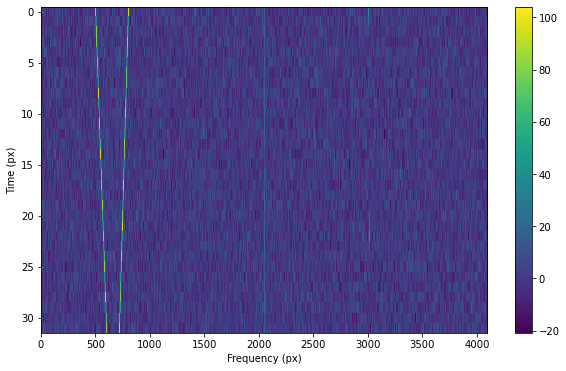

In [9]:
metadata = {'fch1': 6095.214842353016*u.MHz, 
            'dt': 18.25361108*u.s, 
            'df': 2.7939677238464355*u.Hz}

frame = stg.Frame(fchans=2**12*u.pixel,
                  tchans=32*u.pixel,
                  df=metadata['df'],
                  dt=metadata['dt'],
                  fch1=metadata['fch1'])

test_tones = [
  {'f_start': frame.get_frequency(index=500), 'drift_rate': 0.50*u.Hz/u.s, 'snr': 100, 'width': 20*u.Hz},
  {'f_start': frame.get_frequency(index=800), 'drift_rate': -0.40*u.Hz/u.s, 'snr': 100, 'width': 20*u.Hz},
  {'f_start': frame.get_frequency(index=2048), 'drift_rate': 0.00*u.Hz/u.s, 'snr': 20, 'width': 6*u.Hz},
  {'f_start': frame.get_frequency(index=3000), 'drift_rate': 0.07*u.Hz/u.s, 'snr': 50, 'width': 3*u.Hz}
]

noise = frame.add_noise(x_mean=0, x_std=5, noise_type='gaussian')

for tone in test_tones:
    signal = frame.add_signal(stg.constant_path(f_start=tone['f_start'],
                                            drift_rate=tone['drift_rate']),
                          stg.constant_t_profile(level=frame.get_intensity(snr=tone['snr'])),
                          stg.gaussian_f_profile(width=tone['width']),
                          stg.constant_bp_profile(level=1))

fig = plt.figure(figsize=(10, 6))
frame.render()

pd.DataFrame(test_tones)

## Run search

hyperseti       INFO     Kernel time: 0.13ms
hyperseti       INFO     Peak find time: 14.36ms
hyperseti       INFO     Hit merging time: 19.71ms
hyperseti       INFO     Pipeline runtime: 0.05s


,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
3,-0.004783,6095.220564,553.050537,208.0,2048.0,1.0
2,0.071749,6095.223224,1032.027222,224.0,3000.0,1.0
1,0.502241,6095.216239,2811.713379,314.0,500.0,1.0
0,-0.397009,6095.217075,2823.957031,126.0,799.0,1.0


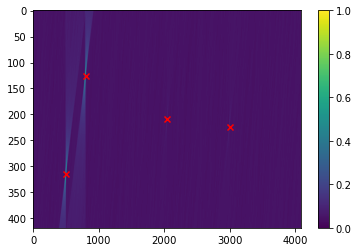

In [20]:
#logger.setLevel(logging.CRITICAL)
logger.setLevel(logging.INFO)

d_cpu  = frame.data.astype('float32')
d_gpu = cp.asarray(d_cpu)

dedopp, metadata, peaks = run_pipeline(d_cpu, metadata, 
                                 max_dd=1.0, min_dd=None, threshold=500, n_boxcar=1)

plt.imshow(dedopp, aspect='auto')
plt.scatter(x=peaks['channel_idx'], y=peaks['driftrate_idx'], marker='x', c='red')
plt.colorbar()

peaks.sort_values('snr')

## Test plotting

In [18]:
merge_hits(peaks).sort_values('channel_idx')

hyperseti       INFO     Hit merging time: 15.33ms


,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
1,0.502241,6095.216239,2811.713379,314.0,500.0,1.0
0,-0.397009,6095.217075,2823.957031,126.0,799.0,1.0
2,0.071749,6095.223224,1032.027222,224.0,3000.0,1.0


In [15]:
h0 = peaks.iloc[9]

padding = 10
nchan_drift = h0['driftrate'] * u.Hz / u.s * metadata['dt'] * frame.shape[0] / metadata['df']
i0 = int(h0['channel_idx'] - padding)
i1 = int(h0['channel_idx'] + nchan_drift + padding)
if i0 < i1:
    pdata = frame.data[:, i0:i1]
else:
    pdata = frame.data[:, i1:i0]

plt.imshow(pdata, aspect='auto')
plt.colorbar()

IndexError: single positional indexer is out-of-bounds

## Test with hdf5 data

In [13]:
class H5Reader(object):

    def __init__(self, fn, gulp_size=2**19):
        self.fn = fn
        
        with h5py.File(fn, mode='r') as h:
            self.metadata = {
                'fch1': h['data'].attrs['fch1'] * u.MHz,
                'dt': h['data'].attrs['tsamp'] * u.s,
                'df': (h['data'].attrs['foff'] * u.MHz).to('Hz')
            }
            self.dshape = h['data'].shape
            
        self.gulp_size = 2**19
        self.n_sub = self.dshape[2] // gulp_size
    
    def read_data_plan(self):
        for ii in range(self.n_sub):
            i0, i1 = ii*self.gulp_size, (ii+1)*self.gulp_size
            md = deepcopy(self.metadata)
            md['fch1'] += md['df'] * i0
            md['i0'] = i0
            md['i1'] = i1
            md['sidx'] = ii
            yield md

    def read_data(self, md):
        t0 = time.time()
        ii = md['sidx']
        with h5py.File(fn, mode='r') as h:
            d = h['data'][:, 0, md['i0']:md['i1']]
        t1 = time.time()
        logger.info(f"## Subband {ii+1}/{self.n_sub} read: {(t1-t0)*1e3:2.2f}ms ##")
        return d

In [14]:
def search_subband_dask(md, h5):
    d_gulp = h5.read_data(md)
    dd, dedopp, peaks = run_pipeline(d_gulp, md, 
                                        max_dd=1.0, min_dd=None, min_distance=20, 
                                        threshold=25, n_boxcar=5)
    return [peaks,]

fn = '/datax/collate_mb/PKS_0262_2018-02-21T17:00/blc01/guppi_58171_08035_757812_G26.37-1.21_0001.0000.hires.hdf'
h5 = H5Reader(fn, gulp_size=2**20)

b = db.from_sequence(h5.read_data_plan(), npartitions=1)

with ProgressBar():
    logger.setLevel(logging.CRITICAL)
    b.map(search_subband_dask, h5).compute()

[                                        ] | 0% Completed |  0.1s


CUDARuntimeError: cudaErrorInitializationError: initialization error

In [16]:
p[0]

,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
157,-0.116055,1513.143838,28.139252,96.0,181602.0,32.0
110,0.197294,1513.143781,26.312689,69.0,181619.0,16.0
81,0.313349,1513.143761,25.945129,59.0,181625.0,8.0
115,-0.394588,1513.061740,25.633871,120.0,206198.0,16.0
77,-0.487432,1513.061737,27.024162,128.0,206199.0,8.0
...,...,...,...,...,...,...
20,-0.591882,1512.007577,46.575520,137.0,522018.0,2.0
1,0.232111,1512.007440,227.498993,66.0,522059.0,1.0
121,0.104450,1512.007433,150.116623,77.0,522061.0,32.0
33,0.290138,1512.007427,326.832550,61.0,522063.0,4.0


In [11]:
h5 = H5Reader(fn, gulp_size=2**20)

b = db.from_sequence(h5.read_data(), npartitions=3)
with ProgressBar():
        b.map(search_coarse_channel, self).compute()

peaks = None
for metadata_gulp, d_gulp in h5.read_data():
    _dd, _dedopp, _peaks = run_pipeline(d_gulp, metadata_gulp, 
                                        max_dd=1.0, min_dd=None, min_distance=10, 
                                        threshold=50, n_boxcar=5)
    if peaks is None:
        peaks = _peaks
    else:
        peaks = pd.concat((peaks, _peaks), ignore_index=True)

hyperseti       INFO     ## Subband 1/22 read: 19.11ms ##
hyperseti       INFO     Normalisation time: 1.05ms
hyperseti       INFO     Kernel time: 0.06ms
hyperseti       INFO     Peak find time: 154.20ms
hyperseti       INFO     --- Boxcar size: 2 ---
hyperseti       INFO     Filter time: 159.58ms
hyperseti       INFO     Peak find time: 126.02ms
hyperseti       INFO     --- Boxcar size: 4 ---
hyperseti       INFO     Filter time: 168.08ms
hyperseti       INFO     Peak find time: 126.16ms
hyperseti       INFO     --- Boxcar size: 8 ---
hyperseti       INFO     Filter time: 167.10ms
hyperseti       INFO     Peak find time: 125.95ms
hyperseti       INFO     --- Boxcar size: 16 ---
hyperseti       INFO     Filter time: 166.95ms
hyperseti       INFO     Peak find time: 126.09ms
hyperseti       INFO     --- Boxcar size: 32 ---
hyperseti       INFO     Filter time: 167.16ms
hyperseti       INFO     Peak find time: 126.06ms
hyperseti       INFO     Hit merging time: 153.60ms
hyperseti       

In [16]:
peaks.sort_values('snr', ascending=False)

,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
399,0.058028,1489.951134,8623.877930,81.0,314233.0,1.0
75,0.023211,1504.916256,6153.699219,84.0,25089.0,2.0
501,-0.034817,1483.293685,6102.118164,89.0,211607.0,2.0
212,-0.034817,1498.397442,3803.042480,89.0,405217.0,4.0
222,0.011606,1498.395827,3654.031006,85.0,405701.0,4.0
...,...,...,...,...,...,...
452,-0.081239,1485.183745,50.557755,93.0,169646.0,8.0
495,-0.081239,1484.373744,50.396687,93.0,412317.0,32.0
26,-0.835598,1510.257650,50.340298,158.0,521996.0,8.0
494,-0.208900,1484.373754,50.206715,104.0,412314.0,32.0


In [69]:
metadata, data = next(d)
metadata['df'] = np.abs(metadata['df'])

hyperseti       INFO     ## Subband 1/44 read: 13.03ms ##


In [87]:
dd, dedopp, peaks = run_pipeline(data, metadata, 
                                 max_dd=1.0, min_dd=None, threshold=50, min_distance=10, n_boxcar=6)

hyperseti       INFO     Normalisation time: 0.70ms
hyperseti       INFO     Kernel time: 0.07ms
hyperseti       INFO     Peak find time: 697.25ms
hyperseti       INFO     --- Boxcar size: 2 ---
hyperseti       INFO     Filter time: 836.55ms
hyperseti       INFO     Peak find time: 126.36ms
hyperseti       INFO     --- Boxcar size: 4 ---
hyperseti       INFO     Filter time: 850.73ms
hyperseti       INFO     Peak find time: 126.72ms
hyperseti       INFO     --- Boxcar size: 8 ---
hyperseti       INFO     Filter time: 854.83ms
hyperseti       INFO     Peak find time: 126.19ms
hyperseti       INFO     --- Boxcar size: 16 ---
hyperseti       INFO     Filter time: 852.93ms
hyperseti       INFO     Peak find time: 126.29ms
hyperseti       INFO     --- Boxcar size: 32 ---
hyperseti       INFO     Filter time: 789.14ms
hyperseti       INFO     Peak find time: 126.45ms
hyperseti       INFO     --- Boxcar size: 64 ---
hyperseti       INFO     Filter time: 807.16ms
hyperseti       INFO     Peak 

In [111]:
peaks.sort_values('snr', ascending=False)

,driftrate,f_start,snr,driftrate_idx,channel_idx,boxcar_size
399,0.058028,1489.951134,8623.877930,81.0,314233.0,1.0
75,0.023211,1504.916256,6153.699219,84.0,25089.0,2.0
501,-0.034817,1483.293685,6102.118164,89.0,211607.0,2.0
830,-0.058028,1460.796772,5519.758789,91.0,135784.0,2.0
212,-0.034817,1498.397442,3803.042480,89.0,405217.0,4.0
...,...,...,...,...,...,...
676,-0.023211,1471.260456,50.089081,88.0,146664.0,1.0
1038,0.661515,1435.857967,50.056583,29.0,267247.0,16.0
1040,0.104450,1435.857857,50.036026,77.0,267280.0,16.0
672,-0.023211,1471.336876,50.026711,88.0,123769.0,2.0


In [12]:
h0 = peaks.iloc[2]

padding = 10
nchan_drift = h0['driftrate'] * u.Hz / u.s * metadata['dt'] * frame.shape[0] / metadata['df']
i0 = int(h0['channel_idx'] - padding)
i1 = int(h0['channel_idx'] + nchan_drift + padding)
if i0 < i1:
    pdata = data[:, i0:i1]
else:
    pdata = data[:, i1:i0]

plt.imshow(pdata, aspect='auto')
plt.colorbar()

NameError: name 'data' is not defined